In [1]:
import scipy.io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#komentarze ze względu na wygodę będą prowadzone po polsku

In [88]:
#wczytanie danych z plików wejściowych
audiots = scipy.io.loadmat('DATA\DREGON_free-flight_speech-high_room1_audiots.mat') 
sourcepos = scipy.io.loadmat('DATA\DREGON_free-flight_speech-high_room1_sourcepos.mat')["source_position"]
rate, data = scipy.io.wavfile.read('DATA\DREGON_free-flight_speech-high_room1.wav')

#zapisanie danych do wektorów
audio_timestamps=audiots["audio_timestamps"]
timestamps=sourcepos["timestamps"][0,0]
azimuth=sourcepos["azimuth"][0,0]
elevation=sourcepos["elevation"][0,0]
distance=sourcepos["distance"][0,0]

In [397]:
timestamps_step=np.zeros((timestamps.size,1))
j=0
l=0
for i in range(0,timestamps.size):
    l=l+j
    j=0
    while not(np.isclose(timestamps[i],audio_timestamps[l+j],rtol=0,atol=1e-4)==True):
        if (i+l+j>audio_timestamps.size):
            print("break")
            break
        else:
            j=j+1
    else:
        timestamps_step[i]=j
        if i % 500==0:
            print(i)
timestamps_step=timestamps_step.astype(int)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


In [455]:
#przygotowanie danych
audio_input=np.zeros((5612*300,8))
azimuth_input=np.zeros((5612,1))
elevation_input=np.zeros((5612,1))
j=0 #licznik dla danych rzeczywistych
l=0 #licznik na dane wychodzące
m=0 #licznik na pominięte dane
for i in range(0,5612):
    j=j+timestamps_step[i,0]
    if(timestamps_step[i]>=300):
        azimuth_input[i]=azimuth[i-m]
        elevation_input[i]=elevation[i-m]
        for k in range(0,299):
            audio_input[i*299+k]=data[j+k,:]
    else:
        print("step is smaller than 300 points, omitting")
        m=m+1


step is smaller than 300 points, omitting
step is smaller than 300 points, omitting
step is smaller than 300 points, omitting
step is smaller than 300 points, omitting
step is smaller than 300 points, omitting
step is smaller than 300 points, omitting
step is smaller than 300 points, omitting
step is smaller than 300 points, omitting
step is smaller than 300 points, omitting
step is smaller than 300 points, omitting


In [659]:
#podział danych na zbiór uczący, walidacyjny i testowy

input=audio_input[0:300*3500,:]
input_val=audio_input[300*3500:300*4500,:]
input_test=audio_input[300*4500:,:]

output=elevation_input[0:3500,0]
output_val=elevation_input[3500:4500,0]
output_test=elevation_input[4500:,0]

print(input.shape)
print(input_val.shape)
print(input_test.shape)
print(output.shape)
print(output_val.shape)
print(output_test.shape)

(1050000, 8)
(300000, 8)
(333600, 8)
(3500,)
(1000,)
(1112,)


In [676]:
def prepare_input(input):
  input_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    input, None, sequence_length=300)
  for batch in input_dataset:
    inputs = batch
    assert np.array_equal(inputs[0], input[:300]) 
    break

input_train0=prepare_input(input[:,0])
input_train1=prepare_input(input[:,1])
input_train2=prepare_input(input[:,2])
input_train3=prepare_input(input[:,3])
input_train4=prepare_input(input[:,4])
input_train5=prepare_input(input[:,5])
input_train6=prepare_input(input[:,6])
input_train7=prepare_input(input[:,7])

input_val0=prepare_input(input_val[:,0])
input_val1=prepare_input(input_val[:,1])
input_val2=prepare_input(input_val[:,2])
input_val3=prepare_input(input_val[:,3])
input_val4=prepare_input(input_val[:,4])
input_val5=prepare_input(input_val[:,5])
input_val6=prepare_input(input_val[:,6])
input_val7=prepare_input(input_val[:,7])

input_test0=prepare_input(input_test[:,0])
input_test1=prepare_input(input_test[:,1])
input_test2=prepare_input(input_test[:,2])
input_test3=prepare_input(input_test[:,3])
input_test4=prepare_input(input_test[:,4])
input_test5=prepare_input(input_test[:,5])
input_test6=prepare_input(input_test[:,6])
input_test7=prepare_input(input_test[:,7])

output0=output
output_val0=output_val
output_test0=output_test

In [677]:
from keras.models import Model
from keras.layers import Dense, Conv1D, MaxPooling1D , GlobalMaxPooling1D, GlobalMaxPooling2D, BatchNormalization, Dropout, Input, concatenate

def make_conv_branch(inputs):
    conv = Conv1D(filters=32, kernel_size=21, dilation_rate=1, activation='relu')(inputs)
    conv = BatchNormalization()(conv)
    conv = Conv1D(filters=64, kernel_size=19, dilation_rate=2, activation='relu')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPooling1D(pool_size=3)(conv)
    conv = Conv1D(filters=128, kernel_size=17, dilation_rate=3, activation='relu')(conv)
    conv = BatchNormalization()(conv)
    conv = Conv1D(filters=256, kernel_size=15, dilation_rate=5, activation='relu')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Conv1D(filters=512, kernel_size=13, dilation_rate=8, activation='relu')(conv)
    conv = BatchNormalization()(conv)
    conv = Conv1D(filters=1024, kernel_size=11, dilation_rate=13, activation='relu')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Conv1D(filters=1024, kernel_size=9, dilation_rate=21, activation='relu')(conv)
    conv = BatchNormalization()(conv)
    conv = Conv1D(filters=1024, kernel_size=7, dilation_rate=34, activation='relu')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Conv1D(filters=1024, kernel_size=7, dilation_rate=55, activation='relu')(conv)
    conv = BatchNormalization()(conv)
    return conv

input1 = Input(shape=(None,300))
input2 = Input(shape=(None,300))
input3 = Input(shape=(None,300))
input4 = Input(shape=(None,300))
input5 = Input(shape=(None,300))
input6 = Input(shape=(None,300))
input7 = Input(shape=(None,300))
input8 = Input(shape=(None,300))

conv1=make_conv_branch(input1)
conv2=make_conv_branch(input2)
conv3=make_conv_branch(input3)
conv4=make_conv_branch(input4)
conv5=make_conv_branch(input5)
conv6=make_conv_branch(input6)
conv7=make_conv_branch(input7)
conv8=make_conv_branch(input8)

merged = concatenate([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8])

z = GlobalMaxPooling1D()(merged)
z = Dropout(0.5)(z)
z = Dense(512, activation='relu')(z)
z = BatchNormalization()(z)
z = Dense(1, activation="linear")(z)

model = Model(inputs=[input1, input2, input3, input4, input5, input6, input7, input8], outputs=z)




In [665]:
print(model.summary())

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_116 (InputLayer)         [(None, None, 300)]  0           []                               
                                                                                                  
 input_117 (InputLayer)         [(None, None, 300)]  0           []                               
                                                                                                  
 input_118 (InputLayer)         [(None, None, 300)]  0           []                               
                                                                                                  
 input_119 (InputLayer)         [(None, None, 300)]  0           []                               
                                                                                           

In [678]:
from keras.optimizers import Adam

init_lr = 1e-4
epochs = 100
opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(loss='mse',loss_weights=4.,metrics='mae', optimizer=opt)

In [679]:
from keras.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

train_input=[input_train0, input_train1, input_train2, input_train3, input_train4, input_train5, input_train6, input_train7]
train_output=output0
valid_input=[input_val0, input_val1, input_val2, input_val3, input_val4, input_val5, input_val6, input_val7]
valid_output=output_val0
history = model.fit(train_input,train_output,validation_data=(valid_input, valid_output),epochs=100,batch_size=300)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'NoneType'>"}), <class 'numpy.ndarray'>

7/7 [==============================] - 0s 1ms/step
6.103515625e-05


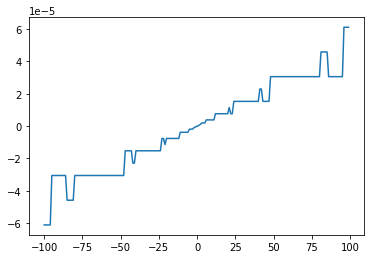

In [9]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['race_output_acc'],name='Train'))
fig.add_trace(go.Scatter(y=history.history['val_race_output_acc'],name='Valid'))
fig.update_layout(height=500, width=700,title='Accuracy for race feature',xaxis_title='Epoch',yaxis_title='Accuracy')
fig.show()